## Лабораторная работа №3.

Дедлайн: 21 мая 23:59

### Часть 1. Overfit it (1.5 points)

Будем работать с датасетом [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) (*hint: он доступен в torchvision*).

Ваша задача состоит в следующем:
1. Обучить сеть, которая покажет >= 0.94 test accuracy.
2. Пронаблюдать и продемонстрировать процесс переобучения сети с увеличением числа параметров (==нейронов) и продемонстрировать это наглядно (например, на графиках).
3. Попробовать частично справиться с переобучением с помощью подходящих приемов (Dropout/batchnorm/augmentation etc.)

*Примечание*: Пункты 2 и 3 взаимосвязаны, в п.3 Вам прелагается сделать полученную в п.2 сеть менее склонной к переобучению. Пункт 1 является независимым от пунктов 2 и 3.

### Было сделано:
1. Часть 1 (полностью)
2. Часть 2 (полностью)
3. Часть 4 (>= 85% (I hope))

In [0]:
import torch
from torchvision import transforms
from torchsummary import summary
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot as plt
import numpy as np
import time
import math
from tqdm import tqdm_notebook as tqdm

import os

device = torch.device("cuda:3")

In [0]:
transform_aug = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

In [0]:
train_dataset = torchvision.datasets.FashionMNIST('./', download=True, train=True, transform=transform_aug)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=5)

test_dataset = torchvision.datasets.FashionMNIST('./', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=5)

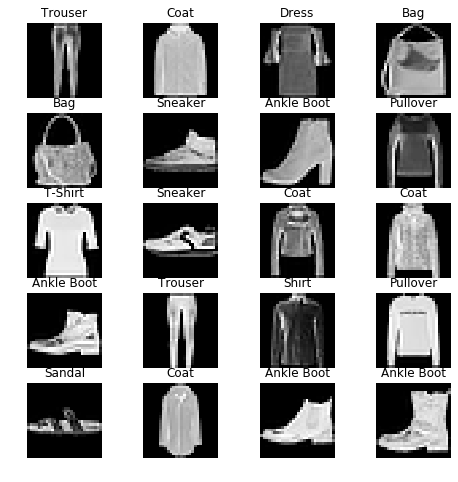

In [0]:
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'};
fig = plt.figure(figsize=(8,8));
columns = 4;
rows = 5;
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(train_dataset));
    img = train_dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

In [0]:
def conv3x3(a_in_planes, a_out_planes, a_stride=1):
    return nn.Conv2d(a_in_planes, a_out_planes,  stride=a_stride,
                     kernel_size=3, padding=1, bias=False)

class CifarResidualBlock(nn.Module):
    expansion = 1
    def __init__(self, a_in_channels, a_out_channels, stride=1, downsample=None):
        super(CifarResidualBlock, self).__init__()
            
        ### TODO - нужно описать используемые блоки
        self.conv1 = conv3x3(a_in_channels, a_out_channels, stride)
        self.conv2 = conv3x3(a_out_channels, a_out_channels)
        self.bn1 = nn.BatchNorm2d(a_in_channels)
        self.bn2 = nn.BatchNorm2d(a_out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        
    def forward(self, x):
        ###TODO - описать forward блок с учетом флагов make_downsample и use_skip_connection
        shortcut = x
        out = self.relu(self.bn1(x))
        
        if self.downsample is not None:
            shortcut = self.downsample(out)
            
        out = self.conv1(out)
        out = self.relu(self.bn2(out))
        out = self.conv2(out)
        out += shortcut
        
        return out

In [0]:
class Wide_ResNet_Cifar(nn.Module):

    def __init__(self, block, layers, width, num_classes=10):
        super(Wide_ResNet_Cifar, self).__init__()
        self.inplanes = 16
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.stack_layers(block, 16*width, layers[0])
        self.layer2 = self.stack_layers(block, 32*width, layers[1], stride=2)
        self.layer3 = self.stack_layers(block, 64*width, layers[2], stride=2)
        self.avgpool = nn.AvgPool2d(6, stride=1)
        self.fc = nn.Linear(512, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def stack_layers(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(self.bn1(out))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)

        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)

        return out


def wide_resnet_cifar(depth, width):
    n = int((depth - 4) / 6)
    return Wide_ResNet_Cifar(CifarResidualBlock, [n, n, n], width)

In [0]:
model = wide_resnet_cifar(40, 2).to(device)
lr = 0.005

def train(num_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(1, num_epochs + 1):
        if epoch == 15:
            optimizer = torch.optim.SGD(model.parameters(), lr = lr)
        if epoch == 30:
            optimizer = torch.optim.SGD(model.parameters(), lr = lr/10)
        for batch_id, (image, label) in enumerate(trainloader):
            label, image = label.to(device), image.to(device)
            output = model(image)
            loss = criterion(output, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch_id % 1000 == 0:
                print('Loss :{:.4f} Epoch[{}/{}]'.format(loss.item(), epoch, num_epochs))
                with torch.no_grad():
                    correct = 0
                    total = 0
                    for image , label in testloader:
                        image = image.to(device)
                        label = label.to(device)
                        outputs = model(image)
                        predicted = torch.argmax(outputs,dim=1)
                        total += label.size(0)
                        correct += (predicted == label).sum().item()
                    print('Accuracy: {} %'.format(100 * correct / total))

In [0]:
train(40)

Loss :2.3619 Epoch[1/40]
Accuracy: 14.35 %
Loss :0.4729 Epoch[2/40]
Accuracy: 81.45 %
Loss :0.3630 Epoch[3/40]
Accuracy: 88.8 %
Loss :0.2046 Epoch[4/40]
Accuracy: 89.22 %
Loss :0.1713 Epoch[5/40]
Accuracy: 90.77 %
Loss :0.2080 Epoch[6/40]
Accuracy: 86.04 %
Loss :0.3791 Epoch[7/40]
Accuracy: 91.24 %
Loss :0.0752 Epoch[8/40]
Accuracy: 91.19 %
Loss :0.2524 Epoch[9/40]
Accuracy: 90.82 %
Loss :0.2487 Epoch[10/40]
Accuracy: 91.63 %
Loss :0.3162 Epoch[11/40]
Accuracy: 92.04 %
Loss :0.2048 Epoch[12/40]
Accuracy: 92.73 %
Loss :0.1659 Epoch[13/40]
Accuracy: 92.18 %
Loss :0.0338 Epoch[14/40]
Accuracy: 91.96 %
Loss :0.0832 Epoch[15/40]
Accuracy: 91.72 %
Loss :0.0961 Epoch[16/40]
Accuracy: 92.6 %
Loss :0.0332 Epoch[17/40]
Accuracy: 92.8 %
Loss :0.1573 Epoch[18/40]
Accuracy: 92.91 %
Loss :0.0726 Epoch[19/40]
Accuracy: 92.94 %
Loss :0.0834 Epoch[20/40]
Accuracy: 93.06 %
Loss :0.0721 Epoch[21/40]
Accuracy: 93.12 %
Loss :0.0496 Epoch[22/40]
Accuracy: 93.17 %
Loss :0.2114 Epoch[23/40]
Accuracy: 93.21 %


In [0]:
class Overfit_Model(nn.Module):
    def __init__(self, num_of_fc):
        super(Overfit_Model, self).__init__()
        self.num_of_fc = num_of_fc
        if num_of_fc == 1:
            self.fc1 = nn.Linear(28 * 28, 10)
        if num_of_fc == 2:
            self.fc1 = nn.Linear(28 * 28, 50)
            self.fc2 = nn.Linear(50, 10)
        if num_of_fc == 3:
            self.fc1 = nn.Linear(28 * 28, 100)
            self.fc2 = nn.Linear(100, 50)
            self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1 ,1, 28*28)
        out = F.relu(self.fc1(x))
        if self.num_of_fc == 2:
            out = F.relu(self.fc2(out))
        if self.num_of_fc == 3:
            out = F.relu(self.fc2(out))
            out = F.relu(self.fc3(out))
        
        return out

In [0]:
train_dataset = torchvision.datasets.FashionMNIST('./', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=5)

test_dataset = torchvision.datasets.FashionMNIST('./', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=5)

In [0]:
def train(model, num_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(1, num_epochs + 1):
        avg_train_loss = 0
        for batch_id, (image, label) in enumerate(trainloader):
            label, image = label.to(device), image.to(device)
            
            output = model(image)
            
            loss = criterion(output.squeeze(), label)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            avg_train_loss += loss.item()
            
        avg_train_loss /= len(trainloader.dataset)
        train_loss.append(avg_train_loss)
        
        avg_test_loss = 0
        with torch.no_grad():
            for image , label in testloader:
                image = image.to(device)
                label = label.to(device)
                outputs = model(image)
                avg_test_loss += criterion(outputs.squeeze(), label)
        avg_test_loss /= len(testloader.dataset)
        test_loss.append(avg_test_loss)
        if epoch % 5 == 0:
            print('Loss :{:.4f} Epoch[{}/{}]'.format(avg_test_loss, epoch, num_epochs))
    with torch.no_grad():
        correct = 0
        total = 0
        for image , label in testloader:
            image = image.to(device)
            label = label.to(device)
            outputs = model(image).squeeze()
            predicted = torch.argmax(outputs,dim=1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
        print('Accuracy: {} %'.format(100 * correct / total))

Loss :0.0172 Epoch[5/50]
Loss :0.0173 Epoch[10/50]
Loss :0.0184 Epoch[15/50]
Loss :0.0178 Epoch[20/50]
Loss :0.0197 Epoch[25/50]
Loss :0.0184 Epoch[30/50]
Loss :0.0187 Epoch[35/50]
Loss :0.0188 Epoch[40/50]
Loss :0.0195 Epoch[45/50]
Loss :0.0191 Epoch[50/50]
Accuracy: 62.43 %


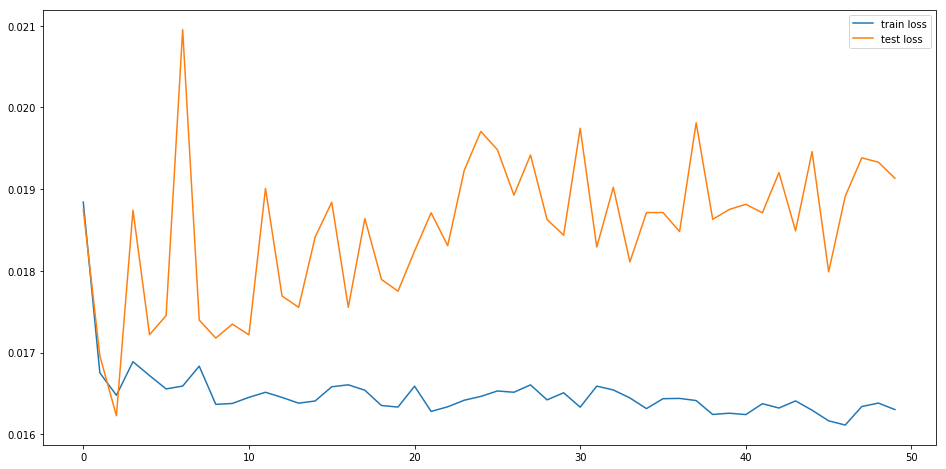

Loss :0.0137 Epoch[5/50]
Loss :0.0139 Epoch[10/50]
Loss :0.0138 Epoch[15/50]
Loss :0.0138 Epoch[20/50]
Loss :0.0141 Epoch[25/50]
Loss :0.0140 Epoch[30/50]
Loss :0.0151 Epoch[35/50]
Loss :0.0142 Epoch[40/50]
Loss :0.0147 Epoch[45/50]
Loss :0.0145 Epoch[50/50]
Accuracy: 74.87 %


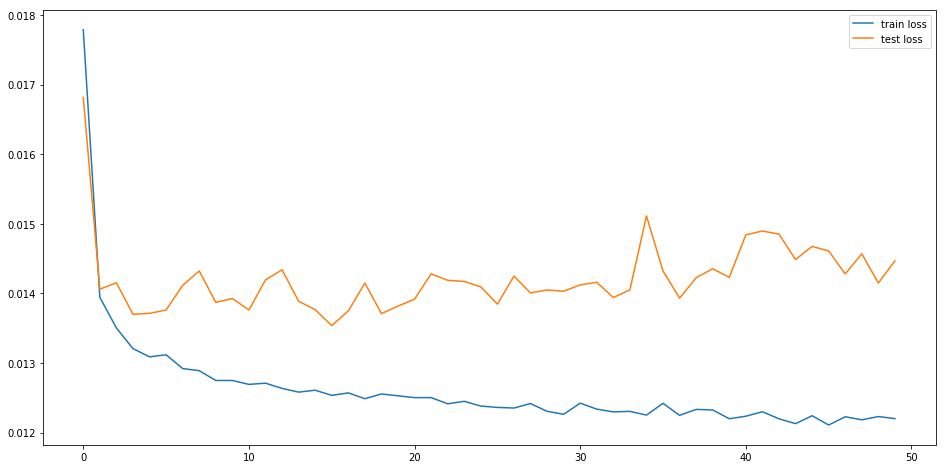

Loss :0.0305 Epoch[5/50]
Loss :0.0303 Epoch[10/50]
Loss :0.0313 Epoch[15/50]
Loss :0.0303 Epoch[20/50]
Loss :0.0304 Epoch[25/50]
Loss :0.0306 Epoch[30/50]
Loss :0.0304 Epoch[35/50]
Loss :0.0304 Epoch[40/50]
Loss :0.0303 Epoch[45/50]
Loss :0.0304 Epoch[50/50]
Accuracy: 19.63 %


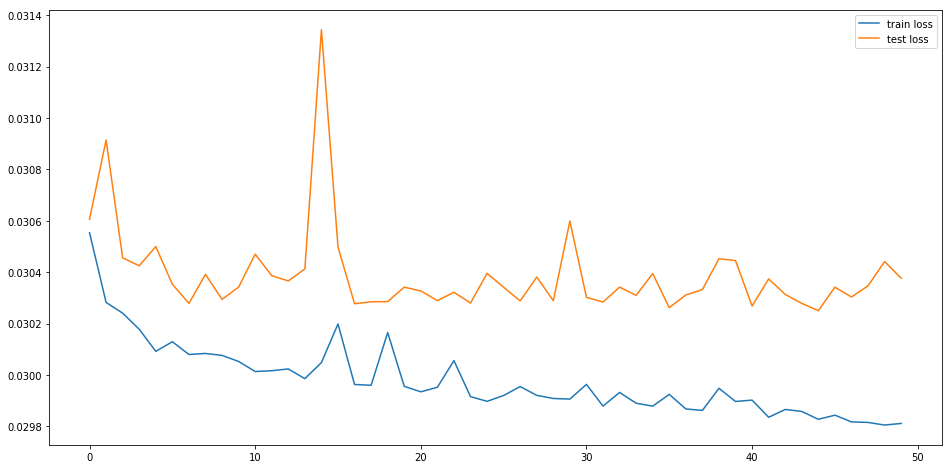

In [0]:
for num_of_fc in range(1, 4):
    train_loss = []
    test_loss = []
    model = Overfit_Model(num_of_fc).to(device)
    train(model, 50)
    plt.figure(figsize=(16, 8))
    plt.plot(train_loss, label="train loss")
    plt.plot(test_loss, label="test loss")
    plt.legend()
    plt.show()

На графиках можно видеть как с падением лосса на трейне увеличивается лосс на тесте, что и является признаком переобучения, при увеличении количества нейронов и количества эпох, это можно наблюдать все лучше и лучше. Попробуем справиться с переобучением при помощи аугментаций нашего датасета, а также добавления слоев батч нормализации. 

In [0]:
class Overfit_Model_Fixed(nn.Module):
    def __init__(self, num_of_fc):
        super(Overfit_Model, self).__init__()
        self.num_of_fc = num_of_fc
        
        if num_of_fc == 2:
            self.fc1 = nn.Linear(28 * 28, 50)
            self.bn1 = nn.BatchNorm1d(50)
            self.fc2 = nn.Linear(50, 10)
        if num_of_fc == 3:
            self.fc1 = nn.Linear(28 * 28, 100)
            self.bn1 = nn.BatchNorm1d(100)
            self.fc2 = nn.Linear(100, 50)
            self.bn2 = nn.BatchNorm1d(50)
            self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = F.relu(self.fc1(out))
        if self.num_of_fc == 2:
            out = F.relu(self.bn1(self.fc2(out)))
        if self.num_of_fc == 3:
            out = F.relu(self.bn1(self.fc2(out)))
            out = F.relu(self.bn2(self.fc3(out)))
        return out

In [0]:
train_dataset = torchvision.datasets.FashionMNIST('./', download=True, train=True, transform=transform_aug)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=5)

test_dataset = torchvision.datasets.FashionMNIST('./', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=5)

Loss :0.0083 Epoch[5/30]
Loss :0.0077 Epoch[10/30]
Loss :0.0081 Epoch[15/30]
Loss :0.0077 Epoch[20/30]
Loss :0.0076 Epoch[25/30]
Loss :0.0081 Epoch[30/30]
Accuracy: 82.59 %


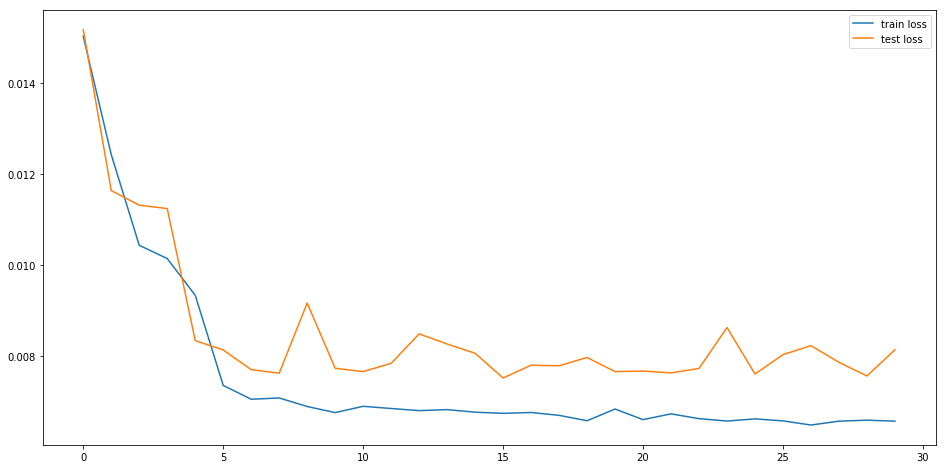

Loss :0.0072 Epoch[5/30]
Loss :0.0077 Epoch[10/30]
Loss :0.0082 Epoch[15/30]
Loss :0.0071 Epoch[20/30]
Loss :0.0069 Epoch[25/30]
Loss :0.0078 Epoch[30/30]
Accuracy: 83.81 %


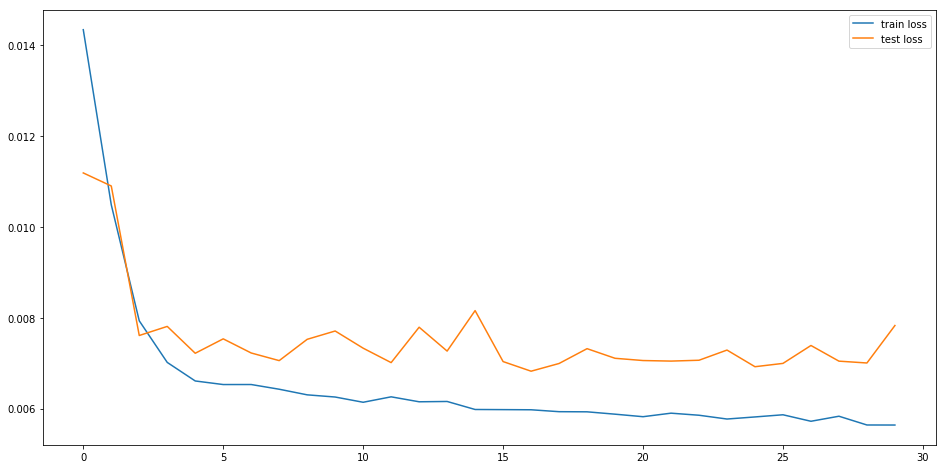

In [0]:
for num_of_fc in range(2, 4):
    train_loss = []
    test_loss = []
    model = Overfit_Model(num_of_fc).to(device)
    train(model, 30)
    plt.figure(figsize=(16, 8))
    plt.plot(train_loss, label="train loss")
    plt.plot(test_loss, label="test loss")
    plt.legend()
    plt.show()

Как видно по графика качество классификации заметно выросло, промежуток между тестовым и валидационным лоссом уменьшился, а также валидационный лосс не особо возрастает при уменьшении трейнового. 

### Часть 2. Almost Shakespeare (1.5 points)

В этой части задания мы научимся генерировать текст с помощью нейронных сетей. Конкретнее, обучим нейронную сеть на сонетах Шекспира и попросим нейросеть написать свой сонет.

Генерация текста обычно включает в себя следующие шаги:
    
1. Загрузка данных.
2. Создание словарей слов/символов.
3. Препроцессинг данных.
4. Обучение модели (нейросети).
5. Генерация нового текста.


#### Часть 1. Предобработка данных

Для начала загрузим данные. Файл с сонетами Шекспира доступен по [ссылке](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). Кроме того, он находится рядом с этим ноутбуком (`sonnetes.txt`).

Базовая предобработка уже сделана: текст состоит непосредственно из поэм Шекспира и названий/номеров глав, все техническая информация удалена.

In [0]:
with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START:TEXT_END]
assert len(text) == 2616

Так как в этот раз мы хотим научиться предсказывать текст, понизим сложность задачи и приведем текст к нижнему регистру.

В настоящий момент переменная `text` представляет собой список из строк. Объедините все строки в одну и приведите к нижнему регистру. 

In [0]:
# Объедините все строки в одну и приведите к нижнему регистру.
# Результат запишите в переменную text.
import string
# Your great code here
text = ''.join(text).lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('Отлично!')

Отлично!


Выделите множество всех символов, с которыми нам довелось встретиться в переменную `tokens`.

In [0]:
tokens = sorted(set(text))

Постройте словарь `token_to_idx` вида <символ>: <индекс> и словарь `idx_to_token` вида <индекс>: <символ>.

In [0]:
tokens

['\n',
 ' ',
 '!',
 "'",
 '(',
 ')',
 ',',
 '-',
 '.',
 ':',
 ';',
 '?',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [0]:
# словарь вида <индекс>:<символ>
# Your great code here
idx_to_token = dict(zip(range(len(tokens)), tokens))
# словарь вида <символ>:<индекс>
# Your great code here
token_to_idx = dict(zip(tokens, range(len(tokens))))

*Комментарий: т.к. у нас всего 38 различных токенов, в этот раз воспользуемся one-hot encoding'ом.*


## Построение модели.

Теперь наша задача - создать и обучить рекуррентную нейронную сеть, которая сможет генерировать что-то похожее на поэзию Шекспира.

Для начала воспользуемся классической RNN, аналогичной построенной на семинаре. 

In [0]:
from random import sample
from IPython.display import clear_output
from torch.autograd import Variable

In [0]:
# Your modified code from class here
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens, emb_size=38, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units
        self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True)
        self.fc = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, hidden):
        out, hidden = self.rnn(x, hidden)
        out = out.contiguous().view(-1, self.num_units)
        out = self.fc(out)
        return out, hidden
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return Variable(torch.zeros(1, batch_size, self.num_units)).to(device)

In [0]:
def get_batches(arr, batch_size, seq_length):
    
    batch_size_total = batch_size * seq_length
    # total number of batches we can make
    n_batches = len(arr)//batch_size_total
    
    # Keep only enough characters to make full batches
    arr = arr[:n_batches * batch_size_total]
    # Reshape into batch_size rows
    arr = arr.reshape((batch_size, -1))
    
    # iterate through the array, one sequence at a time
    for n in range(0, arr.shape[1], seq_length):
        # The features
        x = arr[:, n:n+seq_length]
        # The targets, shifted by one
        y = np.zeros_like(x)
        try:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, n+seq_length]
        except IndexError:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, 0]
        yield x, y

In [0]:
def one_hot_encode(arr, n_labels):   
    # Initialize the the encoded array
    one_hot = np.zeros((np.multiply(*arr.shape), n_labels), dtype=np.float32)
    # Fill the appropriate elements with ones
    one_hot[np.arange(one_hot.shape[0]), arr.flatten()] = 1.
    # Finally reshape it to get back to the original array
    one_hot = one_hot.reshape((*arr.shape, n_labels))
    return one_hot

In [0]:
encoded = np.array([token_to_idx[ch] for ch in text])

In [0]:
def train(net, data, epochs=10, batch_size=10, seq_length=50, lr=0.001, clip=5, 
          temperature=0.2, lstm=False):
    
    net.train()
    
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    val_idx = int(len(data)*(0.9))
    data, val_data = data[:val_idx], data[val_idx:]
    
    counter = 0
    n_chars = len(tokens)
    for e in range(epochs):
        h = net.initial_state(batch_size)
        for x, y in get_batches(data, batch_size, seq_length):
            counter += 1
            x = one_hot_encode(x, n_chars)
            inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
            inputs, targets = inputs.to(device), targets.to(device)
            net.zero_grad()
            
            if lstm:
                h = tuple([each.data for each in h])
            else:
                h = h.detach()
                
            output, h = net(inputs, h)
            loss = criterion(output, targets.view(batch_size*seq_length).long())
            loss.backward()
            
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            opt.step()
        
            if counter % 100 == 0:
                # Get validation loss
                val_h = net.initial_state(batch_size)
                val_losses = []
                net.eval()
                for x, y in get_batches(val_data, batch_size, seq_length):
                    # One-hot encode our data and make them Torch tensors
                    x = one_hot_encode(x, n_chars)
                    x, y = torch.from_numpy(x), torch.from_numpy(y)
                    if lstm:
                        val_h = tuple([each.data for each in val_h])
                    else:
                        val_h = val_h.detach()
                    
                    inputs, targets = x, y
                    inputs, targets = inputs.to(device), targets.to(device)

                    output, val_h = net(inputs, val_h)
                    val_loss = criterion(output, targets.view(batch_size*seq_length).long())
                
                    val_losses.append(val_loss.item())
                
                net.train() # reset to train mode after iterationg through validation data
                
                print("Epoch: {}/{}...".format(e+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.4f}...".format(loss.item()),
                      "Val Loss: {:.4f}".format(np.mean(val_losses)))
                train_loss.append(loss.item())
                test_loss.append(np.mean(val_losses))

In [0]:
def predict(net, char, h=None, temperature=0.2, lstm=False):
        x = np.array([[token_to_idx[char]]])
        x = one_hot_encode(x, len(tokens))
        inputs = torch.from_numpy(x).to(device)
        
        if lstm:
            h = tuple([each.data for each in h])
        else:
            h = h.detach()
            
        out, h = net(inputs, h)
        
        p = F.softmax(out/temperature, dim=1).data
        p = p.cpu().numpy().squeeze()
        char = np.random.choice(len(tokens), p=p/p.sum())
        return idx_to_token[char], h

def sample(net, size, prime='the', temperature=0.2, lstm=False):
        
    net.to(device)
    net.eval()
    
    # First off, run through the prime characters
    chars = [ch for ch in prime]
    h = net.initial_state(1)
    for ch in prime:
        char, h = predict(net, ch, h, temperature, lstm)

    chars.append(char)
    
    for ii in range(size):
        char, h = predict(net, chars[-1], h, temperature, lstm)
        chars.append(char)

    return ''.join(chars)

Постройте график функции потерь в зависимости от номера эпохи.

In [0]:
train_loss, test_loss = [], []
net = CharRNNLoop(len(tokens), rnn_num_units=256).to(device)
train(net, encoded, epochs=200, batch_size=100, seq_length=100)

Epoch: 12/200... Step: 100... Loss: 2.5149... Val Loss: 2.5205
Epoch: 23/200... Step: 200... Loss: 2.1483... Val Loss: 2.2004
Epoch: 34/200... Step: 300... Loss: 2.0490... Val Loss: 2.1136
Epoch: 45/200... Step: 400... Loss: 1.9564... Val Loss: 2.0570
Epoch: 56/200... Step: 500... Loss: 1.8879... Val Loss: 2.0126
Epoch: 67/200... Step: 600... Loss: 1.8155... Val Loss: 1.9704
Epoch: 78/200... Step: 700... Loss: 1.7527... Val Loss: 1.9510
Epoch: 89/200... Step: 800... Loss: 1.7098... Val Loss: 1.9215
Epoch: 100/200... Step: 900... Loss: 1.6704... Val Loss: 1.8971
Epoch: 112/200... Step: 1000... Loss: 1.6536... Val Loss: 1.8880
Epoch: 123/200... Step: 1100... Loss: 1.5649... Val Loss: 1.8754
Epoch: 134/200... Step: 1200... Loss: 1.5105... Val Loss: 1.8833
Epoch: 145/200... Step: 1300... Loss: 1.4985... Val Loss: 1.8925
Epoch: 156/200... Step: 1400... Loss: 1.4553... Val Loss: 1.9043
Epoch: 167/200... Step: 1500... Loss: 1.4072... Val Loss: 1.9292
Epoch: 178/200... Step: 1600... Loss: 1.36

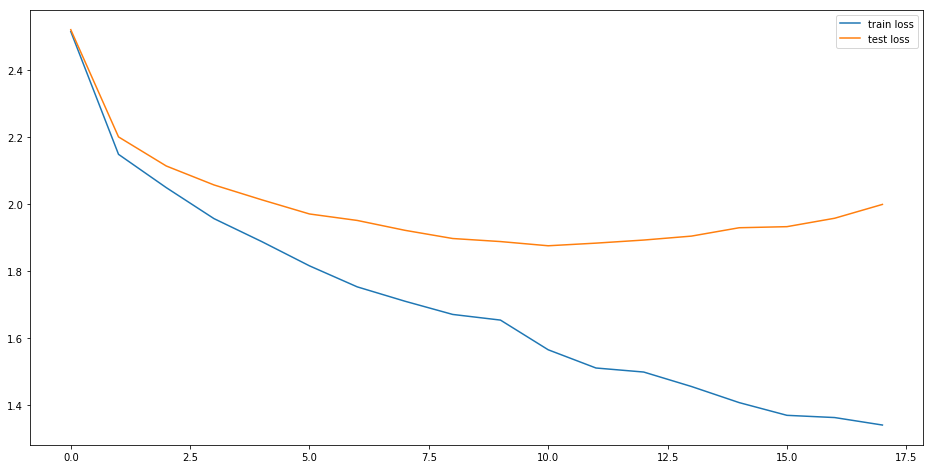

In [0]:
plt.figure(figsize=(16, 8))
plt.plot(train_loss, label="train loss")
plt.plot(test_loss, label="test loss")
plt.legend()
plt.show()

In [0]:
print(sample(net, 500, prime='h'))

he steen to me, my love,
  the oun tome i say the sent and see,
  and beauty stall i sook not in their shathes of the sugh decaine.

  cxxxvi

  if thou art the world mise thee for on when thou destress,
  and see the stould be as it fied
  that thou my love some canter love
  which i save shall not thee i bound,
  and my love ind and thee in thee,
  and sour my beart to has thou art, the sen mo love
  and there of tome, and the world of achinge plowe
  thy love that to the wared of love,
  and so


### Более поэтичная модель

Теперь давайте воспользуемся LSTM слоем вместо классической RNN и сравним результаты.

Снова постройте график функции потерь от числа эпох. Стал ли финальный loss лучше?

In [0]:
# Your modified code from class here
class CharLSTMLoop(nn.Module):
    def __init__(self, num_tokens, emb_size=38, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units
        self.rnn = nn.LSTM(emb_size, rnn_num_units, batch_first=True, num_layers=2, dropout=0.5)
        self.fc = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, hidden):
        out, hidden = self.rnn(x, hidden)
        out = out.contiguous().view(-1, self.num_units)
        out = self.fc(out)
        return out, hidden
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return (Variable(torch.zeros(2, batch_size, self.num_units)).to(device),
                Variable(torch.zeros(2, batch_size, self.num_units)).to(device))

In [0]:
train_loss, test_loss = [], []
net = CharLSTMLoop(len(tokens), rnn_num_units=512).to(device)
train(net, encoded, lstm=True, epochs=100, batch_size=100, seq_length=100)

Epoch: 12/100... Step: 100... Loss: 2.8159... Val Loss: 2.8082
Epoch: 23/100... Step: 200... Loss: 2.1204... Val Loss: 2.1735
Epoch: 34/100... Step: 300... Loss: 1.8140... Val Loss: 1.9233
Epoch: 45/100... Step: 400... Loss: 1.6488... Val Loss: 1.8033
Epoch: 56/100... Step: 500... Loss: 1.5064... Val Loss: 1.7349
Epoch: 67/100... Step: 600... Loss: 1.3793... Val Loss: 1.7040
Epoch: 78/100... Step: 700... Loss: 1.2614... Val Loss: 1.7045
Epoch: 89/100... Step: 800... Loss: 1.1233... Val Loss: 1.7448
Epoch: 100/100... Step: 900... Loss: 1.0126... Val Loss: 1.8048


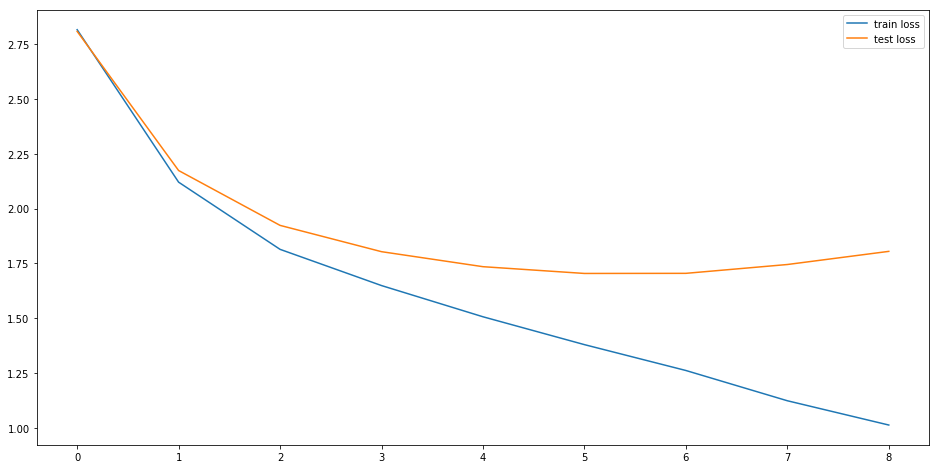

In [0]:
plt.figure(figsize=(16, 8))
plt.plot(train_loss, label="train loss")
plt.plot(test_loss, label="test loss")
plt.legend()
plt.show()

При использовании `LSTM` итоговый лосс стал получше, а также достиг своего минимума на гораздо ранних эпохах.

Сгенерируйте текст с помощью обученной сети для различных значений параметра `temperature`: `[0.1, 0.2, 0.5, 1.0, 2.0]` ("температуры" при генерации). Оцените результаты визуально, попробуйте их проинтерпретировать.

In [0]:
# Text generation with different tempearature values here
for temp in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print('-----Current temp: {}------'.format(temp))
    print(sample(net, 500, prime='a', temperature=temp, lstm=True))

-----Current temp: 0.1------
all all my new,
  and steel doth beauty of thy dead deceiv'd,
  when i say the dead doth that my love and day,
    so that i have shall in the world are deceived:
    but when i am see doth live the score of me:
    the counter of thy poet doth cover thee,
    the world may see thy love and heart and heart
  that thou art fortune of shall i courer leed
  thy self thy beauty of thy deserts are.
  me thou art thou art thou thou art more repent,
  thou art the starst of the world and content,
  when 
-----Current temp: 0.2------
are are strongant.
    then thou art the store to the world are deceived:
  then i am not see my days are deeds to thee,
  when thou art fortune, she whol i the days still,
    and then i dear summer's from thee hath the eye,
  the sear a could doth love the store with thy bow,
    i see the strong of their hadse of the strange;
  the outhard still the world with me thee i do deed,
  that that i how my dead deceived thee more.
  the ow

Здесь можно оставить свои рассуждения касательно интерпретации результатов.

Как можно видеть по результатам температура влияет на уверенность в себе нашей рекуррентной сети. Чем меньше температура тем скучнее будет итоговый текст. При увеличении температуры увеличивается разнообразность предсказаний, однако это может привести к увеличению числа ошибок.

#### Сохранение и загрузка модели

Сохраните обученную модель на диск, затем загрузите ее и сгенерируйте текст. Примеры доступны по [ссылке](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [0]:
# Saving and loading code here
torch.save(net.state_dict(), './model.pt')
loaded_model = CharLSTMLoop(len(tokens), rnn_num_units=512).to(device)
loaded_model.load_state_dict(torch.load('./model.pt'))
loaded_model.eval()
print(sample(loaded_model, 500, lstm=True))

there all thy good repire.
  the contert of the world and contented,
  and such a rame of seen the strack of dead.

  xxii

  why should my say this i beauty should do not,
    and such a could doth love the strength comport,
  when i so fore with the world and cheek died.
  the contern of the praise to the world doth spend
  than this counten every but the stare
  which hours of this with the steel doth chear,
  and summer's from their shadow of thy days,
  and that which thou art all the world a w


Данная часть задания завершена.

#### Полезные ссылки
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Статья Андрея Карпатого про RNN. </a> В качестве примеров рассматриваются задачи генерации Шекспировских текстов, Latex формул, Linux Source Code и детских имен.
2. <a href='https://github.com/karpathy/char-rnn'> Репозиторий с кодом по char-rnn </a> (тоже за авторством Андрея Карпатого)
3. Полезный репозиторий по PyTorch: [ссылка](https://github.com/spro/practical-pytorch`)

____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________

Части задания 3 (HAR classification) и 4 (kaggle) доступны на выбор. Вы можете выполнить одну из них, или обе.

### Часть 3. HAR classification with raw data (2+ points)
__Disclaimer__: В данном задании придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.


Данное задание составлено на основе данного [поста](https://burakhimmetoglu.com/2017/08/22/time-series-classification-with-tensorflow/). С помощью вручную сгенерированных фичей и классических подходов задача распознования движений была решена с точностью 96%. 

Также будет полезным изучить [вот этот](https://github.com/healthDataScience/deep-learning-HAR), а так же [вот этот репозиторий](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition), где к данной задаче рассматривается несколько подходов.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pylab
import warnings as w
import os

%matplotlib inline

In [0]:
import matplotlib
matplotlib.rcParams.update({'font.size':14})

Вернемся к задаче классификации движений на основе [данных](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) из репозитория UCI ([прямая ссылка на скачивание](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip)). 

В этот раз будем работать с исходными, а не предобработанными данными. Данные представляют собой сигналы с гироскопа и акселерометра, закрепленного на теле человека. Каждому семплу соотвествует 9 связанных временных рядов.

В начале приведена визуализация данных на основе PCA над вручную сгенерированными признаками. Для отрисовки графиков (цвет и легенда) нам также понадобятся метки классов.

In [0]:
X_train_with_engineered_features = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "X_train.txt"))
y_train = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "y_train.txt"))

y_train_list = list(y_train)
X_unique = np.array([X_train_with_engineered_features[y_train_list.index(l)]
                             for l in sorted(list(set(y_train)))])

legend_labels = ["WALKING", "WALKING.UP", "WALKING.DOWN", "SITTING", "STANDING", "LAYING"]
colors_list = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta']
mapped_colors = [colors_list[int(i)-1] for i in y_train]

from sklearn.decomposition import PCA
pca = PCA()

X_train_pca = pca.fit_transform(X_train_with_engineered_features)

plt.figure(figsize=(15,10))
pylab.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
             c=mapped_colors)
plt.grid()
for idx, x in enumerate(pca.transform(X_unique)):
    plt.scatter(x[0], 
                x[1], 
                c=colors_list[idx], 
                label=legend_labels[idx])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.legend()

#### Предобработка данных
Предобработка сделана за нас автором [данного репозитория](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition). Будьте осторожны с путями.

In [0]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
]

DATA_PATH = "./"

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)

TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    os.path.join(*[DATASET_PATH, TRAIN, "Inertial Signals/", signal+"train.txt"]) for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    os.path.join(*[DATASET_PATH, TEST, "Inertial Signals/", signal+"test.txt"]) for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = os.path.join(DATASET_PATH, TRAIN, "y_train.txt")
y_test_path = os.path.join(DATASET_PATH, TEST, "y_test.txt")

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)

In [0]:
# Input Data 

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

#### Построение сети и эксперименты. (100% +)

__Ваша задача - построить сеть, которая решит задачу классификации с точностью (`accuracy`) не менее 85%.__
Разбалловка следующая:
* $=$85% - 2 points
* $>=$89% - 2.5 points
* $>=$91% - 3 points


__Warning!__ В сети существует несколько решений данной задачи с использованием различных фреймворков. При проверке это будет учитываться, так что свое решение нужно будет объяснить. Пожалуйста, не копируйте бездумно код, такие задания будут оценены 0 баллов. Если задача не решается - можете обратиться к заданию по классификации изображений.

После выполнения задания заполните небольшой отчет об экспериментах вида "Я пробовал(а) ... подходы и получил(а) ... результаты. Наконец, после N+1 чашки кофе/бессонной ночи у меня получилось, и весь секрет был в ..."

In [0]:
# Your experiments here



  ### Часть 4. Dogs classification.

Предлагаем вам решить задачу классификации пород собак. Вы можете обучить сеть с нуля или же воспользоваться методом fine-tuning'а. Полезная ссылка на [предобученные модели](https://pytorch.org/docs/stable/torchvision/models.html).

Данные можно скачать [отсюда](https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip?dl=0). Датасет представлен 50 классами пород собак, которые можно найти в папке train в соответствующих директориях. При сдаче данной части задания вместе с ноутбуком необходимо отправить .csv-файл с предсказаниями классов тестовой выборки в формате: <имя изображения>,<метка класса> по одному объекту на строку. Ниже приведите код ваших экспериментов и короткий вывод по их результатам.

Будут оцениваться качество классификации (accuracy) на тестовой выборке (2 балла) и проведенные эксперименты (1 балл).
Разбалловка следующая:
* $>=$96% - 2 points
* $>=$85% - 1.5 points
* $>=$70% - 0.75 points

In [0]:
import torchvision.models as models

In [0]:
data_dir = './data/train'
def load_split_train_test(datadir, valid_size = .2):
    train_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(25),
        transforms.RandomResizedCrop(224),7
    ])
    test_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
    ])
    
    train_data = torchvision.datasets.ImageFolder(datadir,       
                    transform=train_transforms)
    test_data = torchvision.datasets.ImageFolder(datadir,
                    transform=test_transforms)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=256)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=256)
    return trainloader, testloader

trainloader, testloader = load_split_train_test(data_dir, .2)
print(trainloader.dataset.classes)

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '6', '7', '8', '9']


In [0]:
num_classes = len(trainloader.dataset.classes)

In [0]:
resnet = torchvision.models.resnet152(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /home/nikita.sveshnikov/.torch/models/resnet152-b121ed2d.pth
241530880it [00:04, 60313297.87it/s]


In [0]:
for param in resnet.parameters():
    param.requires_grad = False

Вместо того, чтобы заменить полносвязный слой у `resnet` на свой, заменим последние два слоя на следующую сеть:
![Image of Net](https://cdn-images-1.medium.com/max/1200/1*SlIyryWkqeWrvwM20McmCQ.png)

In [0]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
      
class ClassifierNew(nn.Module):
    def __init__(self, inp = 2048, h1=1024, d=0.35):
        super().__init__()
        self.ap = nn.AdaptiveAvgPool2d((1,1))
        self.mp = nn.AdaptiveMaxPool2d((1,1))
        self.fla = Flatten()
        self.bn0 = nn.BatchNorm1d(inp*2,eps=1e-05, momentum=0.1, affine=True)
        self.dropout0 = nn.Dropout(d)
        self.fc1 = nn.Linear(inp*2, h1)
        self.bn1 = nn.BatchNorm1d(h1,eps=1e-05, momentum=0.1, affine=True)
        self.dropout1 = nn.Dropout(d)
        
    def forward(self, x):
        ap = self.ap(x)
        mp = self.mp(x)
        x = torch.cat((ap,mp),dim=1)
        x = self.fla(x)
        x = self.bn0(x)
        x = self.dropout0(x)
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout1(x)
        
        return x

In [0]:
resnet.avgpool = ClassifierNew()
resnet.fc = nn.Linear(1024, num_classes)
resnet = resnet.to(device)
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [0]:
def train(model, num_epochs, sched=False):
    criterion = nn.CrossEntropyLoss()
    for epoch in range(1, num_epochs + 1):
        for batch_id, (image, label) in enumerate(trainloader):
            label, image = label.to(device), image.to(device)
            output = model(image)
            loss = criterion(output, label)

            optimizer.zero_grad()
            loss.backward()
            
            if sched:
                scheduler.step()
            optimizer.step()

            if batch_id % 1000 == 0:
                print('Loss :{:.4f} Epoch[{}/{}]'.format(loss.item(), epoch, num_epochs))
                with torch.no_grad():
                    correct = 0
                    total = 0
                    for image , label in testloader:
                        image = image.to(device)
                        print(image.shape)
                        label = label.to(device)
                        outputs = model(image)
                        predicted = torch.argmax(outputs,dim=1)
                        total += label.size(0)
                        correct += (predicted == label).sum().item()
                    print('Accuracy: {} %'.format(100 * correct / total))

Поучим немного голову получившейся сети со случайно выбраным `lr`.

In [0]:
optimizer = torch.optim.SGD(resnet.parameters(), lr=0.02)
train(resnet, 5)

Loss :4.0580 Epoch[1/5]
Accuracy: 2.8611304954640615 %
Loss :2.4666 Epoch[2/5]
Accuracy: 67.4808094905792 %
Loss :1.6888 Epoch[3/5]
Accuracy: 75.64549895324494 %
Loss :1.3098 Epoch[4/5]
Accuracy: 80.80949057920446 %
Loss :1.2262 Epoch[5/5]
Accuracy: 81.99581297976273 %


Будем циклично уменьшать `lr` потому, что в [этой статье](https://arxiv.org/abs/1506.01186) написано так делать.

In [0]:
def cyclical_lr(step_sz, min_lr=0.001, max_lr=1, mode='triangular', scale_func=None, scale_md='cycles', gamma=1.):
    if scale_func == None:
        if mode == 'triangular':
            scale_fn = lambda x: 1.
            scale_mode = 'cycles'
        elif mode == 'triangular2':
            scale_fn = lambda x: 1 / (2.**(x - 1))
            scale_mode = 'cycles'
        elif mode == 'exp_range':
            scale_fn = lambda x: gamma**(x)
            scale_mode = 'iterations'
        else:
            raise ValueError(f'The {mode} is not valid value!')
    else:
        scale_fn = scale_func
        scale_mode = scale_md
    lr_lambda = lambda iters: min_lr + (max_lr - min_lr) * rel_val(iters, step_sz, scale_mode)
    def rel_val(iteration, stepsize, mode):
        cycle = math.floor(1 + iteration / (2 * stepsize))
        x = abs(iteration / stepsize - 2 * cycle + 1)
        if mode == 'cycles':
            return max(0, (1 - x)) * scale_fn(cycle)
        elif mode == 'iterations':
            return max(0, (1 - x)) * scale_fn(iteration)
        else:
            raise ValueError(f'The {scale_mode} is not valid value!')
    return lr_lambda

optimizer = torch.optim.SGD(resnet.parameters(), lr=1.)
clr = cyclical_lr(2000, min_lr=0.001, max_lr=1, mode='triangular2')
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, [clr])

In [0]:
train(resnet, 5, True)

Loss :0.9671 Epoch[1/5]
Accuracy: 83.87997208653175 %
Loss :0.9400 Epoch[2/5]
Accuracy: 82.83321702721562 %
Loss :0.9401 Epoch[3/5]
Accuracy: 85.34542916957432 %
Loss :0.8618 Epoch[4/5]
Accuracy: 86.18283321702721 %
Loss :0.7063 Epoch[5/5]
Accuracy: 86.04326587578507 %


Как можно видеть такой подход неплохо увеличил итоговую точность. Следующее, что мы попробуем, это размораживать отдельные слои `resnet` и потихоньку их обучать.

In [0]:
for name, child in resnet.named_children():
    if name in ['layer4']:
        print(name + ' is unfrozen')
        for param in child.parameters():
            param.requires_grad = True
    else:
        print(name + ' is frozen')
        for param in child.parameters():
            param.requires_grad = False

conv1 is frozen
bn1 is frozen
relu is frozen
maxpool is frozen
layer1 is frozen
layer2 is frozen
layer3 is frozen
layer4 is unfrozen
avgpool is frozen
fc is frozen


In [0]:
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, resnet.parameters()), lr=0.0006, momentum=0.9)

In [0]:
device = torch.device("cuda:1")
resnet = resnet.to(device)
train(resnet, 5)

Loss :0.7427 Epoch[1/5]
Accuracy: 85.90369853454291 %
Loss :0.6937 Epoch[2/5]
Accuracy: 84.78715980460572 %
Loss :0.6268 Epoch[3/5]
Accuracy: 85.06629448709002 %
Loss :0.7492 Epoch[4/5]
Accuracy: 86.11304954640615 %
Loss :0.6370 Epoch[5/5]
Accuracy: 84.43824145150035 %


In [0]:
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, resnet.parameters()), lr=0.05)
clr = cyclical_lr(2000, min_lr=0.00005, max_lr=0.05, mode='triangular2')
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, [clr])
train(resnet, 5, True)

Loss :0.7666 Epoch[1/5]
Accuracy: 87.43893928820656 %
Loss :0.6540 Epoch[2/5]
Accuracy: 84.43824145150035 %
Loss :0.6995 Epoch[3/5]
Accuracy: 83.87997208653175 %
Loss :0.6433 Epoch[4/5]
Accuracy: 85.4152128401954 %
Loss :0.7232 Epoch[5/5]
Accuracy: 84.64759246336358 %


In [0]:
for name, child in resnet.named_children():
    if name in ['layer3']:
        print(name + ' is unfrozen')
        for param in child.parameters():
            param.requires_grad = True
    else:
        print(name + ' is frozen')
        for param in child.parameters():
            param.requires_grad = False

conv1 is frozen
bn1 is frozen
relu is frozen
maxpool is frozen
layer1 is frozen
layer2 is frozen
layer3 is unfrozen
layer4 is frozen
avgpool is frozen
fc is frozen


Как можно видеть итоговое качество не особо повысилось, либо стоило дать обучаться побольше эпох, либо размораживать побольше слоев, либо поумнее выбирать `lr`. Однако мне сейчас `cuda` говорит, что памяти у нее больше нет, поэтому не стоит ее больше беспокоить.

In [0]:
import os
import csv
from PIL import Image
from torch.autograd import Variable

In [0]:
# Saving and loading code here
device = torch.device("cuda:1")
resnet.to(device)
torch.save(resnet.state_dict(), './resnet.pt')

In [0]:
loaded_model = models.resnet152()
loaded_model.avgpool = ClassifierNew()
loaded_model.fc = nn.Linear(1024, 50)
loaded_model.load_state_dict(torch.load('./resnet.pt'))
loaded_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

Сохраним результаты на `test` в отдельный `csv` файл.

In [0]:
device = torch.device("cuda:3")
loaded_model = loaded_model.to(device)
imsize = 224
loader = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
])

def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name)
    image = loader(image).float()
    image = Variable(image, requires_grad=True).unsqueeze(0)
    return image.to(device)  #assumes that you're using GPU

with open('predict.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=' ')
    for file in os.listdir("./data/test"):
        path = os.path.join("./data/test", file)
        image = image_loader(path)
        outputs = loaded_model(image)
        predicted = torch.argmax(outputs, dim=1)
        writer.writerow([file, predicted.item()])